## 데이터

In [1]:
pwd

'C:\\Users\\stand0\\Desktop\\2025\\공공빅데이터분석'

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')

import geopandas as gpd

In [3]:
import matplotlib
import matplotlib.font_manager as fm

# fm.get_fontconfig_fonts()
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
plt.rc('font', family='NanumGothic')
print(plt.rcParams['font.family'])

['NanumGothic']


# 1. 시군구별 인구 및 식료품 소매업체 현황

## 인구 데이터 로드

In [4]:
df_pop_a = pd.read_csv('./food_data/a_pop_cleaned.csv', encoding='utf-8-sig')

# 1) 인구 수치 컬럼만 골라내기 (문자형 key 컬럼 제외)
pop_cols = df_pop_a.columns.drop(['시도명', '시군구명', '읍면동명'])

# 2) 시군구별로 그룹화해서 합산
df_pop_a = (
    df_pop_a
    .groupby(['시도명', '시군구명'])[pop_cols]
    .sum()                    # 시군구별 연령·성별 합계 DataFrame
    .sum(axis=1)              # 각 시군구별로 열(구간) 전부 합산 → Series
    .reset_index(name='총인구')
)

# 결과 확인
df_pop_a

,시도명,시군구명,총인구
0,강원특별자치도,강릉시,207069
1,강원특별자치도,고성군,26824
2,강원특별자치도,동해시,86931
3,강원특별자치도,삼척시,61428
4,강원특별자치도,속초시,80141
...,...,...,...
247,충청북도,청주시 상당구,197250
248,충청북도,청주시 서원구,180794
249,충청북도,청주시 청원구,188866
250,충청북도,청주시 흥덕구,288358


In [5]:
df_pop_d = pd.read_csv('./food_data/d_pop_cleaned.csv', encoding='utf-8-sig') # utf-8

pop_cols = df_pop_d.columns.drop(['법정동코드', '시군구명', '읍면동명', '리명'])

# 2) 시군구별로 그룹화해서 합산
df_pop_d = (
    df_pop_d
    .groupby(['시군구명', '읍면동명'])[pop_cols]
    .sum()                    # 시군구별 연령·성별 합계 DataFrame
    .sum(axis=1)              # 각 시군구별로 열(구간) 전부 합산 → Series
    .reset_index(name='총인구')
)

# 결과 확인
df_pop_d

,시군구명,읍면동명,총인구
0,대덕구,갈전동,41
1,대덕구,대화동,5391
2,대덕구,덕암동,8279
3,대덕구,목상동,5511
4,대덕구,문평동,14
...,...,...,...
169,중구,정생동,199
170,중구,중촌동,14477
171,중구,침산동,134
172,중구,태평동,35874


## 소매점 데이터 로드

In [6]:
df_market_a = pd.read_csv('./food_data/a_market_cleaned.csv', encoding='utf-8-sig')
df_market_a['전체 식료품점'] = df_market_a['종합 소매업'] + df_market_a['전문 식료품 소매업'] + df_market_a['편의점']
df_market_a.head()

,지역,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점
0,강원,159.944444,249.111111,135.777778,544.833333
1,경기,303.409091,336.090909,350.204545,989.704545
2,경남,209.090909,208.227273,156.272727,573.590909
3,경북,192.086957,192.304348,123.000000,507.391304
4,광주,340.400000,364.000000,282.000000,986.400000


In [7]:
df_market_d = pd.read_csv('./food_data/d_market_cleaned.csv', encoding='utf-8-sig') # utf-8
df_market_d['전체 식료품점'] = df_market_d['종합 소매업'] + df_market_d['전문 식료품 소매업'] + df_market_d['편의점']
df_market_d

,시군구명,시군구+법정동,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점
0,대덕구,대덕구 갈전동,0.000000,0.000000,0.000000,0.000000
1,대덕구,대덕구 대화동,19.000000,9.000000,6.000000,34.000000
2,대덕구,대덕구 덕암동,9.000000,6.000000,12.000000,27.000000
3,대덕구,대덕구 목상동,4.000000,5.000000,10.000000,19.000000
4,대덕구,대덕구 문평동,0.000000,0.000000,5.000000,5.000000
...,...,...,...,...,...,...
171,대덕구,평균,9.750000,8.583333,7.583333,25.916667
172,동구,평균,7.333333,9.761905,5.047619,22.142857
173,서구,평균,15.115385,22.192308,18.307692,55.615385
174,유성구,평균,5.867925,6.037736,6.962264,18.867925


In [8]:
# 대전
# 시군구+법정동 생성
df_pop_d['시군구+법정동'] = df_pop_d['시군구명'] + ' ' + df_pop_d['읍면동명']

# 법정동별 인구 합산
pop_cols = df_pop_d.select_dtypes(include='number').columns
df_pop_grouped = (
    df_pop_d.groupby('시군구+법정동')[pop_cols]
    .sum()
    .sum(axis=1)  # 나이별 인구 합계
    .reset_index(name='인구')
)

# market 데이터는 이미 '시군구+법정동' 단위로 소매업 카운트 되어있으므로 그대로 사용
df_market_grouped = df_market_d.copy()

# 병합
df_merged = pd.merge(df_pop_grouped, df_market_grouped, on='시군구+법정동', how='left')

# # NaN 인구 삭제
# df_merged = df_merged.dropna(subset=['인구'])
df_umd_grouped = df_merged # @@@ 뒤에서 필요함

# 시군구 기준 총 개수 계산
df_sgg_grouped = (
    df_merged
    .groupby('시군구명')[['종합 소매업', '전문 식료품 소매업', '편의점', '전체 식료품점', '인구']]
    .sum()
    .reset_index()
)

# '대전 평균' 행 추가
avg_row = df_sgg_grouped[['종합 소매업', '전문 식료품 소매업', '편의점', '전체 식료품점', '인구']].mean()
avg_row['시군구명'] = '대전 평균'
df_sgg_grouped = pd.concat([df_sgg_grouped, pd.DataFrame([avg_row])], ignore_index=True)

In [9]:
# 전국
# df_market_a에서 전국 평균 행 추출
df_market_avg = df_market_a[df_market_a['지역'] == '전국 평균'][['지역', '종합 소매업', '전문 식료품 소매업', '편의점', '전체 식료품점']]
df_market_avg = df_market_avg.rename(columns={'지역': '시군구명'})

# df_pop_a의 총인구 평균 계산
avg_pop = df_pop_a['총인구'].mean()
df_market_avg['인구'] = avg_pop

# 기존 df_sgg_grouped와 병합
df_sgg_grouped_final = pd.concat([df_sgg_grouped, df_market_avg], ignore_index=True)

df_sgg_grouped = df_sgg_grouped_final

df_sgg_grouped

,시군구명,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점,인구
0,대덕구,234.000000,206.000000,182.000000,622.000000,166098.00000
1,동구,308.000000,410.000000,212.000000,930.000000,220008.00000
2,서구,393.000000,577.000000,476.000000,1446.000000,460932.00000
3,유성구,311.000000,320.000000,369.000000,1000.000000,367488.00000
4,중구,299.000000,384.000000,220.000000,903.000000,224869.00000
5,대전 평균,309.000000,379.400000,291.800000,980.200000,287879.00000
6,전국 평균,244.138889,274.623016,223.099206,741.861111,202592.97619


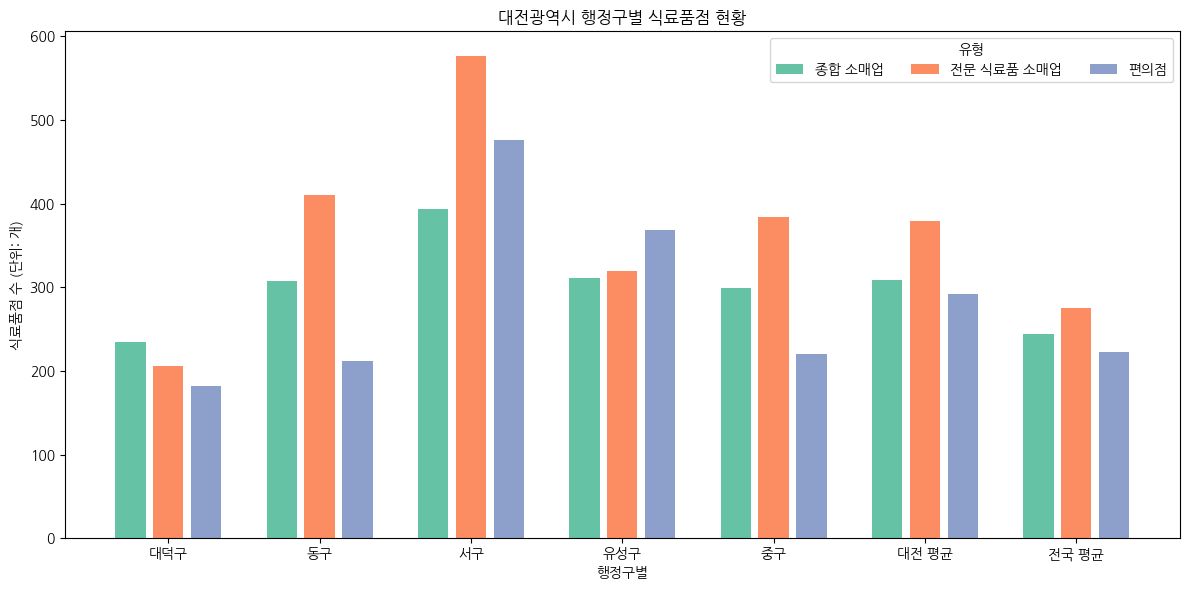

In [10]:
# 대전광역시 시·군·구별 식료품점 현황
df_plot = df_sgg_grouped.copy()
df_plot = df_plot.set_index('시군구명')[['종합 소매업', '전문 식료품 소매업', '편의점', '전체 식료품점']]

labels = df_plot.index.tolist()
x = np.arange(len(labels)) # 각 시군구 위치
bar_width = 0.2 # 막대 너비
gap = 0.05 # 막대 간 간격 조절용

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - bar_width - gap, df_plot['종합 소매업'], width=bar_width, label='종합 소매업', color='#66c2a5')
ax.bar(x, df_plot['전문 식료품 소매업'], width=bar_width, label='전문 식료품 소매업', color='#fc8d62')
ax.bar(x + bar_width + gap, df_plot['편의점'], width=bar_width, label='편의점', color='#8da0cb')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0)
ax.set_xlabel('행정구별')
ax.set_ylabel('식료품점 수 (단위: 개)')
ax.set_title('대전광역시 행정구별 식료품점 현황')
ax.legend(title='유형', ncol=3)
plt.tight_layout()
plt.show()

# 2. 인구 1천 명당 시군구별 인구 및 식료품 소매업체 현황

In [11]:
# 인구 1천 명당 점포 수 계산
df_sgg_grouped_1000 = pd.DataFrame()
df_sgg_grouped_1000['시군구명'] = df_sgg_grouped['시군구명']
df_sgg_grouped_1000['종합 소매업'] = df_sgg_grouped['종합 소매업'] / ((df_sgg_grouped['인구']+1) / 1000)
df_sgg_grouped_1000['전문 식료품 소매업'] = df_sgg_grouped['전문 식료품 소매업'] / ((df_sgg_grouped['인구']+1) / 1000)
df_sgg_grouped_1000['편의점'] = df_sgg_grouped['편의점'] / ((df_sgg_grouped['인구']+1) / 1000)
df_sgg_grouped_1000['전체 식료품점'] = df_sgg_grouped['전체 식료품점'] / ((df_sgg_grouped['인구']+1) / 1000)
df_sgg_grouped_1000

,시군구명,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점
0,대덕구,1.408798,1.240224,1.095732,3.744755
1,동구,1.399943,1.863560,0.963597,4.227100
2,서구,0.852618,1.251809,1.032688,3.137115
3,유성구,0.846284,0.870774,1.004112,2.721170
4,중구,1.329657,1.707653,0.978343,4.015653
5,대전 평균,1.073364,1.317910,1.013617,3.404891
6,전국 평균,1.205065,1.355534,1.101213,3.661812


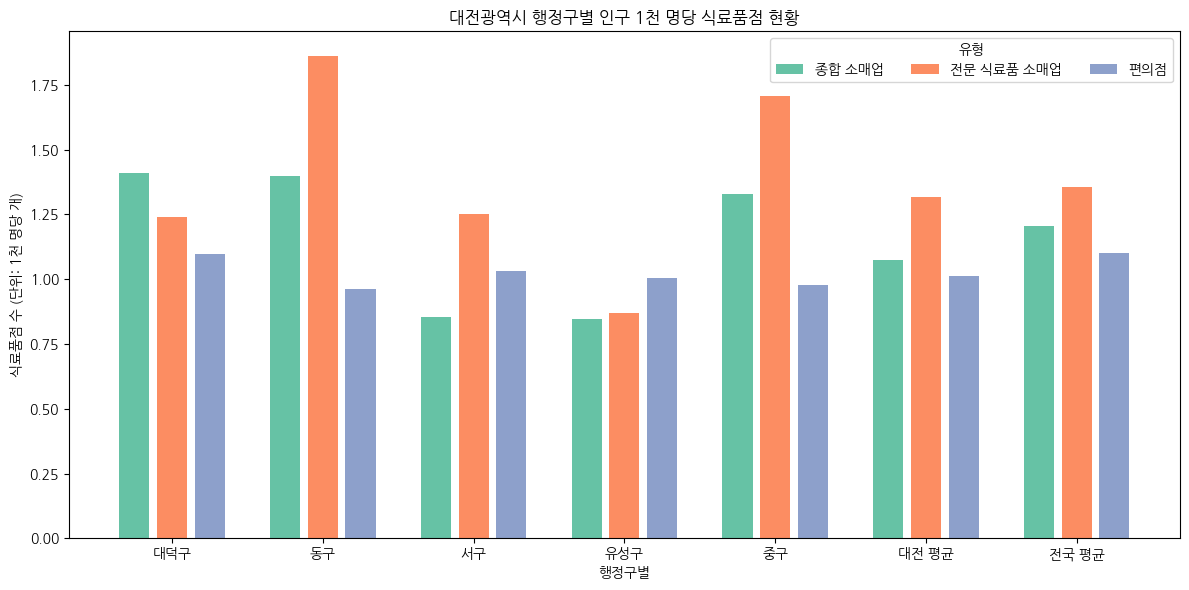

In [12]:
# 대전광역시 시·군·구별 인구 1천 명당 식료품점 현황
df_plot = df_sgg_grouped_1000.copy()
df_plot = df_plot.set_index('시군구명')[['종합 소매업', '전문 식료품 소매업', '편의점']]

labels = df_plot.index.tolist()
x = np.arange(len(labels)) # 각 시군구 위치
bar_width = 0.2 # 막대 너비
gap = 0.05 # 막대 간 간격 조절용

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - bar_width - gap, df_plot['종합 소매업'], width=bar_width, label='종합 소매업', color='#66c2a5')
ax.bar(x, df_plot['전문 식료품 소매업'], width=bar_width, label='전문 식료품 소매업', color='#fc8d62')
ax.bar(x + bar_width + gap, df_plot['편의점'], width=bar_width, label='편의점', color='#8da0cb')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0)
ax.set_xlabel('행정구별')
ax.set_ylabel('식료품점 수 (단위: 1천 명당 개)')
ax.set_title('대전광역시 행정구별 인구 1천 명당 식료품점 현황')
ax.legend(title='유형', ncol=3)
plt.tight_layout()
plt.show()

# 3. 읍·면·동 별 인구 천 명당 식료품점 현황

In [13]:
df_umd_grouped # 대전구 문평동 -> 전체 식료품점 5에 인구 14 맞는지 확인!

,시군구+법정동,인구,시군구명,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점
0,대덕구 갈전동,41,대덕구,0.0,0.0,0.0,0.0
1,대덕구 대화동,5391,대덕구,19.0,9.0,6.0,34.0
2,대덕구 덕암동,8279,대덕구,9.0,6.0,12.0,27.0
3,대덕구 목상동,5511,대덕구,4.0,5.0,10.0,19.0
4,대덕구 문평동,14,대덕구,0.0,0.0,5.0,5.0
...,...,...,...,...,...,...,...
169,중구 정생동,199,중구,1.0,0.0,0.0,1.0
170,중구 중촌동,14477,중구,11.0,12.0,8.0,31.0
171,중구 침산동,134,중구,2.0,0.0,0.0,2.0
172,중구 태평동,35874,중구,24.0,59.0,11.0,94.0


In [14]:
# 인구 1천 명당 점포 수 계산
df_umd_grouped_1000 = pd.DataFrame()
df_umd_grouped_1000['시군구명'] = df_umd_grouped['시군구명']
df_umd_grouped_1000['종합 소매업'] = df_umd_grouped['종합 소매업'] / (df_umd_grouped['인구'] / 1000)
df_umd_grouped_1000['전문 식료품 소매업'] = df_umd_grouped['전문 식료품 소매업'] / (df_umd_grouped['인구'] / 1000)
df_umd_grouped_1000['편의점'] = df_umd_grouped['편의점'] / (df_sgg_grouped['인구'] / 1000)
df_umd_grouped_1000['전체 식료품점'] = df_umd_grouped['전체 식료품점'] / (df_umd_grouped['인구'] / 1000)
df_umd_grouped_1000

,시군구명,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점
0,대덕구,0.000000,0.000000,0.000000,0.000000
1,대덕구,3.524393,1.669449,0.027272,6.306808
2,대덕구,1.087088,0.724725,0.026034,3.261263
3,대덕구,0.725821,0.907276,0.027212,3.447650
4,대덕구,0.000000,0.000000,0.022235,357.142857
...,...,...,...,...,...
169,중구,5.025126,0.000000,NaN,5.025126
170,중구,0.759826,0.828901,NaN,2.141328
171,중구,14.925373,0.000000,NaN,14.925373
172,중구,0.669008,1.644645,NaN,2.620282


In [15]:
# 인구 1천 명당 점포 수 계산
df_umd_grouped_1000 = pd.DataFrame()
df_umd_grouped_1000['시군구+법정동'] = df_umd_grouped['시군구+법정동']
df_umd_grouped_1000['종합 소매업'] = df_umd_grouped['종합 소매업'] / (df_umd_grouped['인구'] / 1000)
df_umd_grouped_1000['전문 식료품 소매업'] = df_umd_grouped['전문 식료품 소매업'] / (df_umd_grouped['인구'] / 1000)
df_umd_grouped_1000['편의점'] = df_umd_grouped['편의점'] / (df_umd_grouped['인구'] / 1000)
df_umd_grouped_1000['전체 식료품점'] = df_umd_grouped['전체 식료품점'] / (df_umd_grouped['인구'] / 1000)
df_umd_grouped_1000['인구'] = df_umd_grouped['인구']
df_umd_grouped_1000

,시군구+법정동,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점,인구
0,대덕구 갈전동,0.000000,0.000000,0.000000,0.000000,41
1,대덕구 대화동,3.524393,1.669449,1.112966,6.306808,5391
2,대덕구 덕암동,1.087088,0.724725,1.449450,3.261263,8279
3,대덕구 목상동,0.725821,0.907276,1.814553,3.447650,5511
4,대덕구 문평동,0.000000,0.000000,357.142857,357.142857,14
...,...,...,...,...,...,...
169,중구 정생동,5.025126,0.000000,0.000000,5.025126,199
170,중구 중촌동,0.759826,0.828901,0.552601,2.141328,14477
171,중구 침산동,14.925373,0.000000,0.000000,14.925373,134
172,중구 태평동,0.669008,1.644645,0.306629,2.620282,35874


In [16]:
df_umd_grouped_1000.sort_values('전체 식료품점', ascending=True).head(20) # 오름차순 top-20

,시군구+법정동,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점,인구
0,대덕구 갈전동,0.0,0.0,0.0,0.0,41
8,대덕구 삼정동,0.0,0.0,0.0,0.0,120
18,대덕구 용호동,0.0,0.0,0.0,0.0,87
48,동구 오동,0.0,0.0,0.0,0.0,42
42,동구 소호동,0.0,0.0,0.0,0.0,143
45,동구 신촌동,0.0,0.0,0.0,0.0,39
38,동구 상소동,0.0,0.0,0.0,0.0,354
34,동구 사성동,0.0,0.0,0.0,0.0,25
57,동구 주산동,0.0,0.0,0.0,0.0,164
58,동구 주촌동,0.0,0.0,0.0,0.0,61


## 인구 1천 명 당 점포수 계산
- 상하위 일정 비율(예: 1~5%)의 값을 상한 또는 하한 값으로 대체



In [17]:
df_umd_grouped_1000['전체 식료품점'].describe()

count    171.000000
mean      13.492214
std       49.921387
min        0.000000
25%        2.131542
50%        3.372981
75%        6.480474
max      500.000000
Name: 전체 식료품점, dtype: float64

In [18]:
# 90분위 값을 상한으로 설정해서 극단값의 
upper_limit = df_umd_grouped_1000['전체 식료품점'].quantile(0.90)
df_umd_grouped_1000['전체 식료품점_capped'] = df_umd_grouped_1000['전체 식료품점'].clip(upper=upper_limit)
df_umd_grouped_1000['전체 식료품점_capped'].describe()

count    171.000000
mean       5.366872
std        5.359682
min        0.000000
25%        2.131542
50%        3.372981
75%        6.480474
max       17.660044
Name: 전체 식료품점_capped, dtype: float64

## 지도 JSON 파일 가져오기

### 컬럼 확인
- EMD_CD: 읍면동 코드(대전 - 30)
 
- EMD_NM: 읍면동명

- geometry: 공간(지도) 정보

- COL_ADM_SE: 행정구역 구분 코드(예: 법정동, 행정동 등)

- SGG_OID: 시군구 고유 ID

In [19]:
# 데이터 불러오기
data = gpd.read_file("./food_data/LSMD_ADM_SECT_UMD_30_202505.shp", encoding='cp949')
daejeon = data[data['EMD_CD'].str.startswith('30')]

In [20]:
daejeon

,EMD_CD,COL_ADM_SE,EMD_NM,SGG_OID,geometry
0,30110107,30110,판암동,3363,"POLYGON ((240138.64 413718.994, 240139.185 413..."
1,30110126,30110,효평동,3346,"POLYGON ((240495.584 420426.648, 240511.773 42..."
2,30110119,30110,정동,2705,"POLYGON ((238468.622 415228.476, 238473.435 41..."
3,30110102,30110,인동,3351,"POLYGON ((238843.284 414267.582, 238852.143 41..."
4,30110132,30110,사성동,3345,"POLYGON ((245382.677 421506.914, 245386.375 42..."
...,...,...,...,...,...
172,30230103,30230,읍내동,130,"POLYGON ((236780.498 420133.674, 236785.029 42..."
173,30230101,30230,오정동,123,"POLYGON ((237696.697 418432.843, 237690.13 418..."
174,30230102,30230,대화동,122,"POLYGON ((237696.697 418432.843, 237660.507 41..."
175,30230107,30230,송촌동,121,"POLYGON ((239075.242 419196.141, 239195.872 41..."


In [21]:
daejeon['COL_ADM_SE'].unique()

array(['30110', '30140', '30170', '30200', '30230'], dtype=object)

In [22]:
col_adm_se_to_name = {
    30110: "동구",
    30140: "중구",
    30170: "서구",
    30200: "유성구",
    30230: "대덕구"
}

# SGG_NM(시군구명) 또는 SGG_OID(시군구코드)를 활용해서 법정동과 시군구 채우기
daejeon['법정동'] = daejeon['EMD_NM'].astype(str)
daejeon['시군구'] = daejeon['COL_ADM_SE'].astype(int).map(col_adm_se_to_name)
daejeon['시군구+법정동'] = daejeon['시군구'] + ' ' + daejeon['법정동']

daejeon # daejeon 지리데이터

,EMD_CD,COL_ADM_SE,EMD_NM,SGG_OID,geometry,법정동,시군구,시군구+법정동
0,30110107,30110,판암동,3363,"POLYGON ((240138.64 413718.994, 240139.185 413...",판암동,동구,동구 판암동
1,30110126,30110,효평동,3346,"POLYGON ((240495.584 420426.648, 240511.773 42...",효평동,동구,동구 효평동
2,30110119,30110,정동,2705,"POLYGON ((238468.622 415228.476, 238473.435 41...",정동,동구,동구 정동
3,30110102,30110,인동,3351,"POLYGON ((238843.284 414267.582, 238852.143 41...",인동,동구,동구 인동
4,30110132,30110,사성동,3345,"POLYGON ((245382.677 421506.914, 245386.375 42...",사성동,동구,동구 사성동
...,...,...,...,...,...,...,...,...
172,30230103,30230,읍내동,130,"POLYGON ((236780.498 420133.674, 236785.029 42...",읍내동,대덕구,대덕구 읍내동
173,30230101,30230,오정동,123,"POLYGON ((237696.697 418432.843, 237690.13 418...",오정동,대덕구,대덕구 오정동
174,30230102,30230,대화동,122,"POLYGON ((237696.697 418432.843, 237660.507 41...",대화동,대덕구,대덕구 대화동
175,30230107,30230,송촌동,121,"POLYGON ((239075.242 419196.141, 239195.872 41...",송촌동,대덕구,대덕구 송촌동


In [23]:
set_daejeon = set(daejeon['시군구+법정동'].unique())
set_grouped = set(df_umd_grouped_1000['시군구+법정동'].unique())

# df_umd_grouped_1000에는 있는데 daejeon에는 없는 항목
only_in_grouped = set_grouped - set_daejeon

# daejeon에는 있는데 df_umd_grouped_1000에는 없는 항목
only_in_daejeon = set_daejeon - set_grouped

# 결과 출력
print("⬅ df_umd_grouped_1000에는 있는데 daejeon에는 없는 항목")
print(only_in_grouped)

print("\n➡ daejeon에는 있는데 df_umd_grouped_1000에는 없는 항목")
print(only_in_daejeon) # 대덕구 황호동, 동구 용계동, 대덕구 부수동은 인구 집계 안됨

⬅ df_umd_grouped_1000에는 있는데 daejeon에는 없는 항목
set()

➡ daejeon에는 있는데 df_umd_grouped_1000에는 없는 항목
{'대덕구 황호동', '대덕구 부수동', '동구 용계동'}


In [24]:
df_umd_grouped_1000

,시군구+법정동,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점,인구,전체 식료품점_capped
0,대덕구 갈전동,0.000000,0.000000,0.000000,0.000000,41,0.000000
1,대덕구 대화동,3.524393,1.669449,1.112966,6.306808,5391,6.306808
2,대덕구 덕암동,1.087088,0.724725,1.449450,3.261263,8279,3.261263
3,대덕구 목상동,0.725821,0.907276,1.814553,3.447650,5511,3.447650
4,대덕구 문평동,0.000000,0.000000,357.142857,357.142857,14,17.660044
...,...,...,...,...,...,...,...
169,중구 정생동,5.025126,0.000000,0.000000,5.025126,199,5.025126
170,중구 중촌동,0.759826,0.828901,0.552601,2.141328,14477,2.141328
171,중구 침산동,14.925373,0.000000,0.000000,14.925373,134,14.925373
172,중구 태평동,0.669008,1.644645,0.306629,2.620282,35874,2.620282


In [25]:
# 병합
daejeon_merged = daejeon.merge(df_umd_grouped_1000, on='시군구+법정동', how='left')

# 다시 GeoDataFrame으로 변경하기
daejeon_merged = gpd.GeoDataFrame(daejeon_merged, geometry='geometry', crs=daejeon.crs)

In [26]:
daejeon_merged

,EMD_CD,COL_ADM_SE,EMD_NM,SGG_OID,geometry,법정동,시군구,시군구+법정동,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점,인구,전체 식료품점_capped
0,30110107,30110,판암동,3363,"POLYGON ((240138.64 413718.994, 240139.185 413...",판암동,동구,동구 판암동,0.681663,1.101148,0.471921,2.254732,19071.0,2.254732
1,30110126,30110,효평동,3346,"POLYGON ((240495.584 420426.648, 240511.773 42...",효평동,동구,동구 효평동,6.289308,0.000000,0.000000,6.289308,159.0,6.289308
2,30110119,30110,정동,2705,"POLYGON ((238468.622 415228.476, 238473.435 41...",정동,동구,동구 정동,16.209476,59.850374,3.740648,79.800499,802.0,17.660044
3,30110102,30110,인동,3351,"POLYGON ((238843.284 414267.582, 238852.143 41...",인동,동구,동구 인동,0.457247,2.133821,0.304832,2.895900,6561.0,2.895900
4,30110132,30110,사성동,3345,"POLYGON ((245382.677 421506.914, 245386.375 42...",사성동,동구,동구 사성동,0.000000,0.000000,0.000000,0.000000,25.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,30230103,30230,읍내동,130,"POLYGON ((236780.498 420133.674, 236785.029 42...",읍내동,대덕구,대덕구 읍내동,1.092697,0.910581,0.364232,2.367510,5491.0,2.367510
173,30230101,30230,오정동,123,"POLYGON ((237696.697 418432.843, 237690.13 418...",오정동,대덕구,대덕구 오정동,3.056052,2.310674,2.534287,7.901014,13416.0,7.901014
174,30230102,30230,대화동,122,"POLYGON ((237696.697 418432.843, 237660.507 41...",대화동,대덕구,대덕구 대화동,3.524393,1.669449,1.112966,6.306808,5391.0,6.306808
175,30230107,30230,송촌동,121,"POLYGON ((239075.242 419196.141, 239195.872 41...",송촌동,대덕구,대덕구 송촌동,0.791484,0.712335,0.910206,2.414025,25269.0,2.414025


In [27]:
daejeon_merged = daejeon_merged.fillna(0) # null 값 0으로 대체

# 병합되지 않은 행 개수 (null 값)
null_count = daejeon_merged['전체 식료품점'].isnull().sum()
null_count = daejeon_merged['전체 식료품점_capped'].isnull().sum()
print(f"병합되지 않은 행 수: {null_count}")

# 병합 실패한 지역들 확인
failed_merge = daejeon_merged[daejeon_merged['전체 식료품점'].isnull()]
failed_merge = daejeon_merged[daejeon_merged['전체 식료품점_capped'].isnull()]

print("인구 수집이 안된 지역들:")
print(failed_merge[['시군구+법정동', 'EMD_NM']].head(10))

병합되지 않은 행 수: 0
인구 수집이 안된 지역들:
Empty DataFrame
Columns: [시군구+법정동, EMD_NM]
Index: []


# 4. 읍명동 천 명당 식료품점 수  지도 시각화

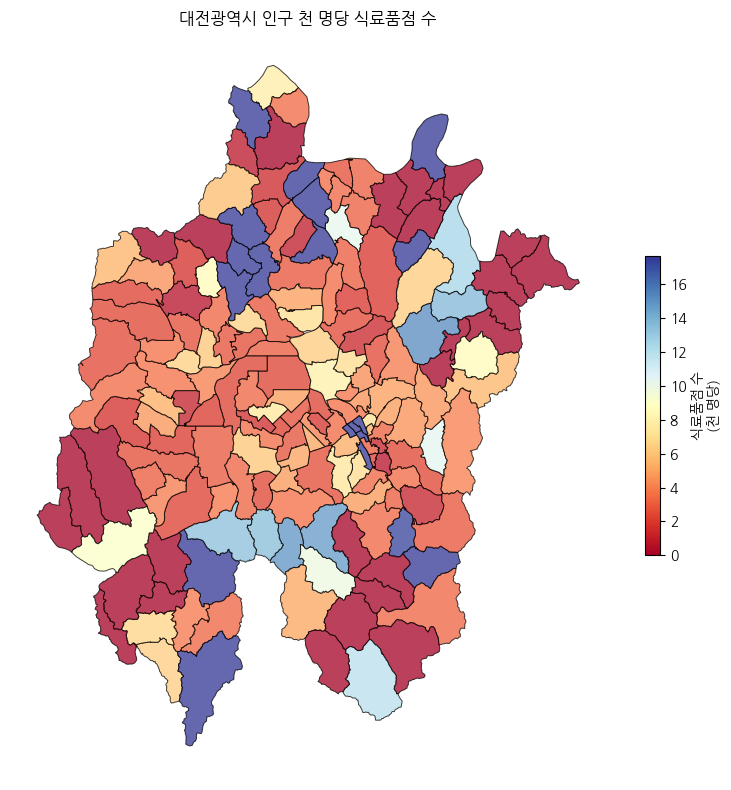

In [28]:
# 4. 히트맵 시각화
fig, ax = plt.subplots(figsize=(8, 8))

daejeon_merged.plot(
    column='전체 식료품점_capped',
    ax=ax,
    edgecolor='black',
    linewidth=0.7,
    legend=True,
    cmap='RdYlBu',
    alpha=0.75,
    legend_kwds={
        'shrink': 0.4,             # ← 레전드 높이 축소
        'label': '식료품점 수\n(천 명당)',  # ← 범례 라벨 텍스트
        'orientation': 'vertical'  # 또는 'horizontal'
    }

)

ax.set_title('대전광역시 인구 천 명당 식료품점 수')
ax.axis('off')
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# 5. 시군구 천 명당 식료품점 수  지도 시각화

In [29]:
df_sgg_grouped_1000

,시군구명,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점
0,대덕구,1.408798,1.240224,1.095732,3.744755
1,동구,1.399943,1.863560,0.963597,4.227100
2,서구,0.852618,1.251809,1.032688,3.137115
3,유성구,0.846284,0.870774,1.004112,2.721170
4,중구,1.329657,1.707653,0.978343,4.015653
5,대전 평균,1.073364,1.317910,1.013617,3.404891
6,전국 평균,1.205065,1.355534,1.101213,3.661812


In [30]:
muni_url = "https://raw.githubusercontent.com/southkorea/southkorea-maps/master/gadm/json/skorea-municipalities-geo.json"
# muni_url = "https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2018/json/skorea-municipalities-2018-geo.json"

muni = gpd.read_file(muni_url)

daejeon_muni = muni[muni["NAME_1"] == "Daejeon"].copy()

# 시군구 영어 -> 한글
eng2kor = {
    "Daedeok": "대덕구",
    "Dong": "동구",
    "Jung": "중구",
    "Seo": "서구",
    "Yuseong": "유성구"
}

# 시군구별
daejeon_muni["시군구명"] = daejeon_muni["NAME_2"].map(eng2kor)

# 병합
daejeon_muni_merged = daejeon_muni.merge(df_sgg_grouped_1000, on='시군구명', how='left')

# 점포 수 0인 지역 강조

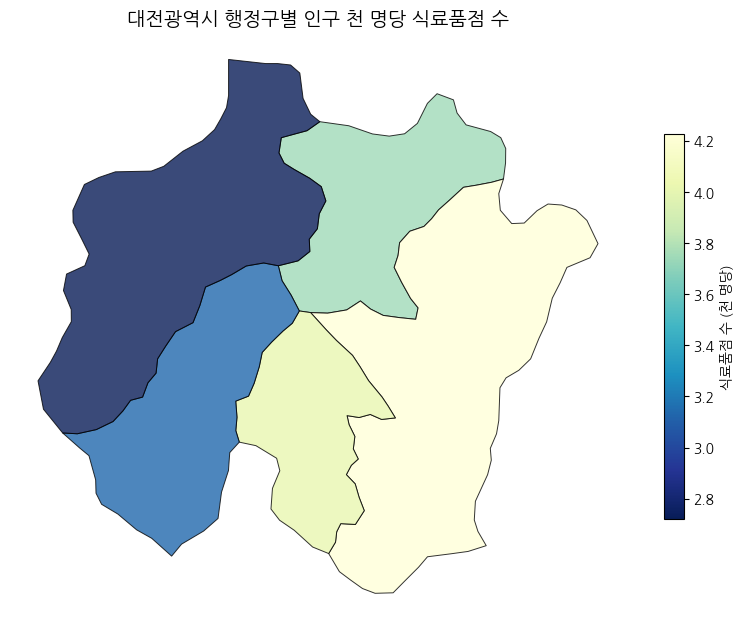

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

daejeon_muni_merged.plot(
    column='전체 식료품점',
    ax=ax,
    edgecolor='black',
    linewidth=0.7,
    legend=True,
    cmap='YlGnBu_r',  # 추천 색상
    alpha=0.8,
    legend_kwds={
        'shrink': 0.5,
        'label': '식료품점 수 (천 명당)',
        'orientation': 'vertical'
    }
)

ax.set_title('대전광역시 행정구별 인구 천 명당 식료품점 수', fontsize=14)
ax.axis('off')
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

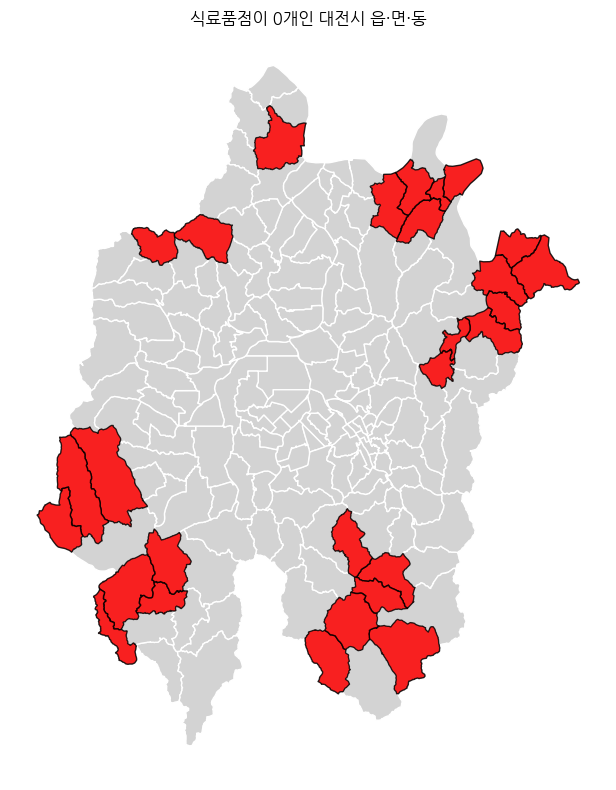

In [32]:
zero_store = daejeon_merged[daejeon_merged['전체 식료품점'] == 0]

fig, ax = plt.subplots(figsize=(8, 8))

daejeon_merged.plot(ax=ax, color='lightgray', edgecolor='white')
zero_store.plot(ax=ax, color='red', edgecolor='black', alpha=0.85)

ax.set_title('식료품점이 0개인 대전시 읍·면·동') 
ax.axis('off')
plt.tight_layout()
plt.show()

In [72]:
zero_store['EMD_NM'].unique()

array(['사성동', '오동', '상소동', '주촌동', '내탑동', '신촌동', '용계동', '주산동', '소호동',
       '장척동', '어남동', '금동', '구완동', '원정동', '용촌동', '봉곡동', '우명동', '추목동',
       '수남동', '성북동', '세동', '송정동', '금고동', '갈전동', '삼정동', '용호동', '황호동',
       '부수동'], dtype=object)

# 65세 이상 인구 전국과 대전 파이차트 시각화

In [33]:
df_pop_a = pd.read_csv('./food_data/a_pop_cleaned.csv', encoding='utf-8-sig')
df_pop_a.columns

Index(['시도명', '시군구명', '읍면동명', '0-4세_남자', '0-4세_여자', '5-9세_남자', '5-9세_여자',
       '10-14세_남자', '10-14세_여자', '15-19세_남자', '15-19세_여자', '20-24세_남자',
       '20-24세_여자', '25-29세_남자', '25-29세_여자', '30-34세_남자', '30-34세_여자',
       '35-39세_남자', '35-39세_여자', '40-44세_남자', '40-44세_여자', '45-49세_남자',
       '45-49세_여자', '50-54세_남자', '50-54세_여자', '55-59세_남자', '55-59세_여자',
       '60-64세_남자', '60-64세_여자', '65-69세_남자', '65-69세_여자', '70-74세_남자',
       '70-74세_여자', '75-79세_남자', '75-79세_여자', '80-84세_남자', '80-84세_여자',
       '85-89세_남자', '85-89세_여자', '90-94세_남자', '90-94세_여자', '95-99세_남자',
       '95-99세_여자', '100세_남자', '100세_여자', '101세이상_남자', '101세이상_여자'],
      dtype='object')

In [34]:
df_pop_d = pd.read_csv('./food_data/d_pop_cleaned.csv', encoding='utf-8-sig')
df_pop_d.head()

,법정동코드,시군구명,읍면동명,리명,0-4세_남자,0-4세_여자,5-9세_남자,5-9세_여자,10-14세_남자,10-14세_여자,...,85-89세_남자,85-89세_여자,90-94세_남자,90-94세_여자,95-99세_남자,95-99세_여자,100세_남자,100세_여자,101세이상_남자,101세이상_여자
0,3011010100,동구,원동,NaN,1,2,2,3,3,6,...,3,10,1,1,0,2,0,0,0,0
1,3011010200,동구,인동,NaN,66,64,68,82,119,105,...,42,89,14,28,0,16,0,0,2,1
2,3011010300,동구,효동,NaN,11,14,25,30,40,30,...,31,35,8,27,2,5,0,0,0,0
3,3011010400,동구,천동,NaN,542,452,378,345,424,418,...,32,77,4,18,0,9,0,1,0,1
4,3011010500,동구,가오동,NaN,130,119,250,256,430,420,...,38,91,5,31,2,12,0,0,0,1


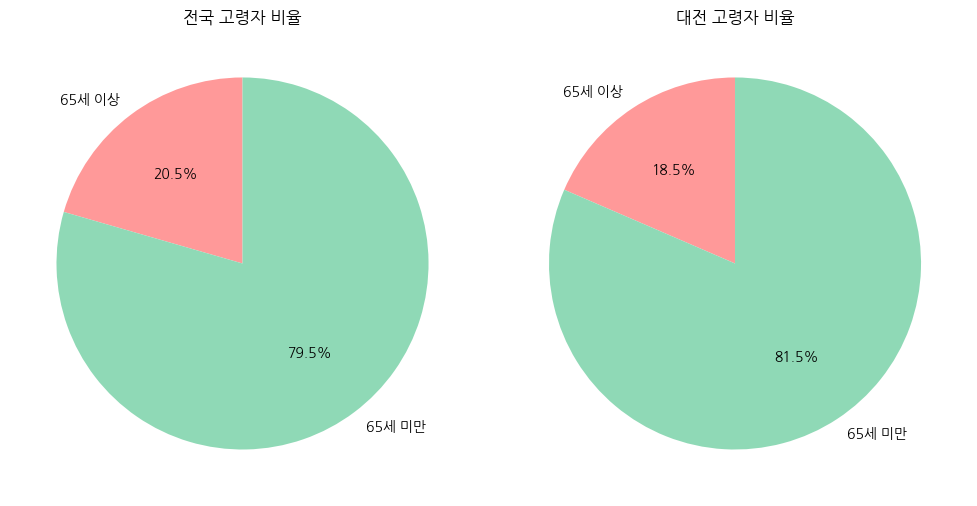

In [35]:
# 65세 이상 연령대 컬럼 리스트 생성
elder_cols = [col for col in df_pop_a.columns if any(age in col for age in ['65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100세', '101세이상'])]
younger_cols = [col for col in df_pop_a.columns if col not in elder_cols and col not in ['시도명', '시군구명', '읍면동명']]

# 전국 합계
a_senior = df_pop_a[elder_cols].sum().sum()
a_younger = df_pop_a[younger_cols].sum().sum()

# 대전 필터링 후 합계
d_senior = df_pop_d[elder_cols].sum().sum()
d_younger = df_pop_d[younger_cols].sum().sum()

# 파이차트 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

labels = ['65세 이상', '65세 미만']
colors = ['#ff9999', '#8fd9b6']

axes[0].pie([a_senior, a_younger], labels=labels, autopct='%.1f%%', startangle=90, colors=colors)
axes[0].set_title('전국 고령자 비율')

axes[1].pie([d_senior, d_younger], labels=labels, autopct='%.1f%%', startangle=90, colors=colors)
axes[1].set_title('대전 고령자 비율')

plt.tight_layout()
plt.show()

# 읍면동별 고령 인구 수 Top-10

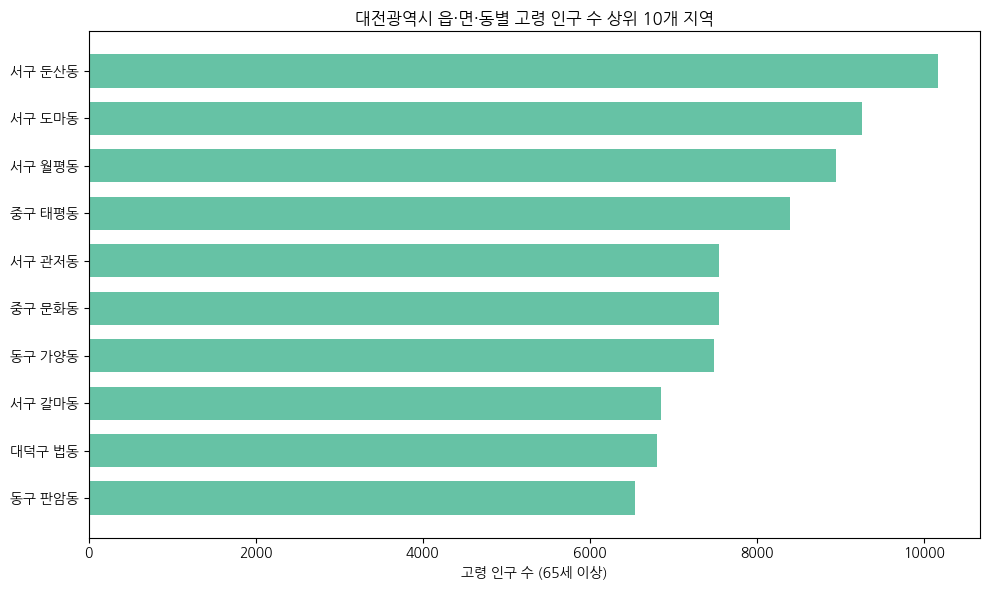

In [36]:
# 시군구+읍면동 컬럼 생성
df_pop_d['시군구+법정동'] = df_pop_d['시군구명'].str.strip() + ' ' + df_pop_d['읍면동명'].str.strip()

# 65세 이상 연령대 컬럼 목록 지정
elder_cols = [col for col in df_pop_d.columns if any(age in col for age in ['65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100세', '101세이상'])]

# 각 동별 고령 인구 총합 계산
df_elder_sum = df_pop_d[['시군구+법정동'] + elder_cols].copy()
df_elder_sum['고령 인구 수'] = df_elder_sum[elder_cols].sum(axis=1)

# 고령 인구 많은 상위 10개 동 추출
top10 = df_elder_sum[['시군구+법정동', '고령 인구 수']].sort_values(by='고령 인구 수', ascending=False).head(10)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(top10['시군구+법정동'][::-1], top10['고령 인구 수'][::-1], height=0.7, color='#66c2a5')
plt.xlabel("고령 인구 수 (65세 이상)")
plt.title("대전광역시 읍·면·동별 고령 인구 수 상위 10개 지역")
plt.tight_layout()
plt.show()

In [73]:
top10

,시군구+법정동,고령 인구 수
80,서구 둔산동,10164
72,서구 도마동,9261
81,서구 월평동,8943
57,중구 태평동,8394
84,서구 관저동,7553
59,중구 문화동,7549
13,동구 가양동,7486
79,서구 갈마동,6854
157,대덕구 법동,6808
6,동구 판암동,6546


# 식료품점 접근성 진단

### 면적 데이터 추가

In [37]:
import fiona
import pandas as pd
from shapely.geometry import shape, Polygon, MultiPolygon

# 파일 경로
shp_path = "./food_data/LSMD_ADM_SECT_UMD_30_202505.shp"

# 컬럼 포함하여 다시 records 생성
records = []
with fiona.open(shp_path, 'r', encoding='cp949') as src:
    for feat in src:
        props = feat['properties']
        geom = shape(feat['geometry'])
        if props['EMD_CD'].startswith("30"):
            records.append({
                "EMD_CD": props["EMD_CD"],
                "COL_ADM_SE": int(props["COL_ADM_SE"]),
                "EMD_NM": props["EMD_NM"],
                "SGG_OID": props["SGG_OID"],
                "geometry": geom
            })

# DataFrame 생성
daejeon = pd.DataFrame(records)

# 자치구 매핑
col_adm_se_to_name = {
    30110: "동구",
    30140: "중구",
    30170: "서구",
    30200: "유성구",
    30230: "대덕구"
}
daejeon['법정동'] = daejeon['EMD_NM'].astype(str)
daejeon['시군구'] = daejeon['COL_ADM_SE'].map(col_adm_se_to_name)
daejeon['시군구+법정동'] = daejeon['시군구'] + ' ' + daejeon['법정동']

# 면적 계산 함수 (m² → km²)
def calculate_area_km2(geom):
    if isinstance(geom, (Polygon, MultiPolygon)):
        return geom.area / 1_000_000
    return None

# 면적 컬럼 추가
daejeon['면적(km²)'] = daejeon['geometry'].apply(calculate_area_km2)

In [38]:
daejeon

,EMD_CD,COL_ADM_SE,EMD_NM,SGG_OID,geometry,법정동,시군구,시군구+법정동,면적(km²)
0,30110107,30110,판암동,3363,"POLYGON ((240138.6398610314 413718.9942101604,...",판암동,동구,동구 판암동,3.614023
1,30110126,30110,효평동,3346,POLYGON ((240495.58370733974 420426.6477491886...,효평동,동구,동구 효평동,6.539989
2,30110119,30110,정동,2705,POLYGON ((238468.62166982566 415228.4758387827...,정동,동구,동구 정동,0.317871
3,30110102,30110,인동,3351,POLYGON ((238843.28409815129 414267.5822643658...,인동,동구,동구 인동,0.418281
4,30110132,30110,사성동,3345,POLYGON ((245382.6774598396 421506.91386069654...,사성동,동구,동구 사성동,2.414110
...,...,...,...,...,...,...,...,...,...
172,30230103,30230,읍내동,130,"POLYGON ((236780.4977022507 420133.6737354498,...",읍내동,대덕구,대덕구 읍내동,2.456410
173,30230101,30230,오정동,123,POLYGON ((237696.69696796229 418432.8427695752...,오정동,대덕구,대덕구 오정동,3.066002
174,30230102,30230,대화동,122,POLYGON ((237696.69696796229 418432.8427695752...,대화동,대덕구,대덕구 대화동,3.176308
175,30230107,30230,송촌동,121,"POLYGON ((239075.2416371973 419196.1410293861,...",송촌동,대덕구,대덕구 송촌동,1.944979


In [39]:
df_umd_grouped

,시군구+법정동,인구,시군구명,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점
0,대덕구 갈전동,41,대덕구,0.0,0.0,0.0,0.0
1,대덕구 대화동,5391,대덕구,19.0,9.0,6.0,34.0
2,대덕구 덕암동,8279,대덕구,9.0,6.0,12.0,27.0
3,대덕구 목상동,5511,대덕구,4.0,5.0,10.0,19.0
4,대덕구 문평동,14,대덕구,0.0,0.0,5.0,5.0
...,...,...,...,...,...,...,...
169,중구 정생동,199,중구,1.0,0.0,0.0,1.0
170,중구 중촌동,14477,중구,11.0,12.0,8.0,31.0
171,중구 침산동,134,중구,2.0,0.0,0.0,2.0
172,중구 태평동,35874,중구,24.0,59.0,11.0,94.0


In [40]:
# 면적 데이터와 소매점, 인구 데이터 결합
daejeon_merged_area = daejeon.merge(df_umd_grouped, on='시군구+법정동', how='left')

In [41]:
daejeon_merged_area.head()

,EMD_CD,COL_ADM_SE,EMD_NM,SGG_OID,geometry,법정동,시군구,시군구+법정동,면적(km²),인구,시군구명,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점
0,30110107,30110,판암동,3363,"POLYGON ((240138.6398610314 413718.9942101604,...",판암동,동구,동구 판암동,3.614023,19071.0,동구,13.0,21.0,9.0,43.0
1,30110126,30110,효평동,3346,POLYGON ((240495.58370733974 420426.6477491886...,효평동,동구,동구 효평동,6.539989,159.0,동구,1.0,0.0,0.0,1.0
2,30110119,30110,정동,2705,POLYGON ((238468.62166982566 415228.4758387827...,정동,동구,동구 정동,0.317871,802.0,동구,13.0,48.0,3.0,64.0
3,30110102,30110,인동,3351,POLYGON ((238843.28409815129 414267.5822643658...,인동,동구,동구 인동,0.418281,6561.0,동구,3.0,14.0,2.0,19.0
4,30110132,30110,사성동,3345,POLYGON ((245382.6774598396 421506.91386069654...,사성동,동구,동구 사성동,2.414110,25.0,동구,0.0,0.0,0.0,0.0


In [42]:
# 65세 이상 읍면동별 인구 추출

# 65세 이상 연령대 컬럼 리스트 생성
elder_cols = [col for col in df_pop_d.columns if any(age in col for age in [
    '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100세', '101세이상'
])]

df_pop_d['65세이상_인구수'] = df_pop_d[elder_cols].sum(axis=1)
df_pop_d

,법정동코드,시군구명,읍면동명,리명,0-4세_남자,0-4세_여자,5-9세_남자,5-9세_여자,10-14세_남자,10-14세_여자,...,90-94세_남자,90-94세_여자,95-99세_남자,95-99세_여자,100세_남자,100세_여자,101세이상_남자,101세이상_여자,시군구+법정동,65세이상_인구수
0,3011010100,동구,원동,NaN,1,2,2,3,3,6,...,1,1,0,2,0,0,0,0,동구 원동,134
1,3011010200,동구,인동,NaN,66,64,68,82,119,105,...,14,28,0,16,0,0,2,1,동구 인동,1984
2,3011010300,동구,효동,NaN,11,14,25,30,40,30,...,8,27,2,5,0,0,0,0,동구 효동,1004
3,3011010400,동구,천동,NaN,542,452,378,345,424,418,...,4,18,0,9,0,1,0,1,동구 천동,1963
4,3011010500,동구,가오동,NaN,130,119,250,256,430,420,...,5,31,2,12,0,0,0,1,동구 가오동,1728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,3023012000,대덕구,이현동,NaN,1,1,0,0,1,1,...,0,0,0,1,0,0,0,0,대덕구 이현동,48
170,3023012100,대덕구,갈전동,NaN,0,0,0,1,0,0,...,0,1,0,2,0,0,0,0,대덕구 갈전동,23
171,3023012400,대덕구,삼정동,NaN,0,0,2,1,0,2,...,1,0,0,0,0,0,0,0,대덕구 삼정동,51
172,3023012500,대덕구,미호동,NaN,2,2,0,1,4,3,...,0,2,0,1,0,0,0,1,대덕구 미호동,87


In [43]:
# 최종적으로 병합
daejeon_merged_area = daejeon_merged_area.merge(df_pop_d[['시군구+법정동', '65세이상_인구수']], on='시군구+법정동', how='left')

In [44]:
# null값 0으로
daejeon_merged_area = daejeon_merged_area.fillna(0)

In [45]:
daejeon_merged_area.isnull().sum()

EMD_CD        0
COL_ADM_SE    0
EMD_NM        0
SGG_OID       0
geometry      0
법정동           0
시군구           0
시군구+법정동       0
면적(km²)       0
인구            0
시군구명          0
종합 소매업        0
전문 식료품 소매업    0
편의점           0
전체 식료품점       0
65세이상_인구수     0
dtype: int64

In [46]:
daejeon_merged_area.columns

Index(['EMD_CD', 'COL_ADM_SE', 'EMD_NM', 'SGG_OID', 'geometry', '법정동', '시군구',
       '시군구+법정동', '면적(km²)', '인구', '시군구명', '종합 소매업', '전문 식료품 소매업', '편의점',
       '전체 식료품점', '65세이상_인구수'],
      dtype='object')

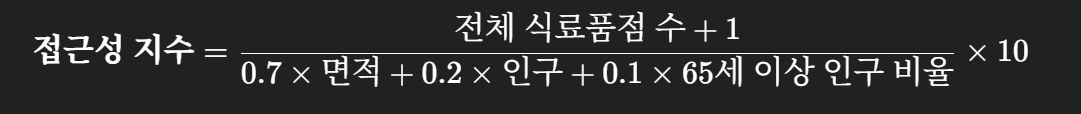

- 분자: 식료품점 수가 많을수록 접근성 지수가 증가합니다.

- 분모: 면적이 넓고, 인구가 많고, 고령자 비율이 높을수록 접근성 지수는 낮아집니다.

> - 접근성 지수가 크다 →
상대적으로 많은 식료품점이 있고,
면적이 작거나 인구가 적고, 고령자 비율이 낮아
→ 신선 식품 접근성이 우수한 지역으로 해석할 수 있습니다.

> - 접근성 지수가 작다 (0에 가까움) →
식료품점 수는 적고,
면적이 넓거나 인구·고령자 비율이 높아
→ 식품 사막 가능성이 높은 지역입니다.

> - +1 보정: 전체 식료품점 수 = 0인 경우를 방지하면서도, 접근성 제로(0)로 떨어지는 걸 막음
> - 가중치는 전체 접근성 지수의 표준편차가 가장 작은 조합

In [47]:
# 접근성 지수 계산
# 고령인구
daejeon_merged_area['65세이상_비율'] = daejeon_merged_area['65세이상_인구수'] / daejeon_merged_area['인구']

# 접근성 지수 계산
daejeon_merged_area['접근성 지수'] = ((daejeon_merged_area['전체 식료품점']+1) / (
    0.7 * daejeon_merged_area['면적(km²)'] +
    0.2 * daejeon_merged_area['인구'] +
    0.1 * daejeon_merged_area['65세이상_비율']
)) * 10

In [48]:
daejeon_merged_area = daejeon_merged_area.fillna(0)
daejeon_merged_area.shape

(177, 18)

In [49]:
# 정규화

# 사분위수 계산
Q1 = daejeon_merged_area['접근성 지수'].quantile(0.25)
Q3 = daejeon_merged_area['접근성 지수'].quantile(0.75)
IQR = Q3 - Q1

# 하한, 상한 정의
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 치환
daejeon_merged_area['접근성 지수_clipped'] = daejeon_merged_area['접근성 지수'].clip(lower=lower_bound, upper=upper_bound)

In [50]:
daejeon_merged_area['접근성 지수_clipped'].describe()

count    177.000000
mean       0.378191
std        0.329079
min        0.000000
25%        0.139920
50%        0.241005
75%        0.497607
max        1.034138
Name: 접근성 지수_clipped, dtype: float64

In [51]:
# GeoDataFrame 변환
daejeon_merged_area = gpd.GeoDataFrame(daejeon_merged_area, geometry='geometry', crs=daejeon_merged.crs)  # 혹은 기존 daejeon에서 crs 가져오기

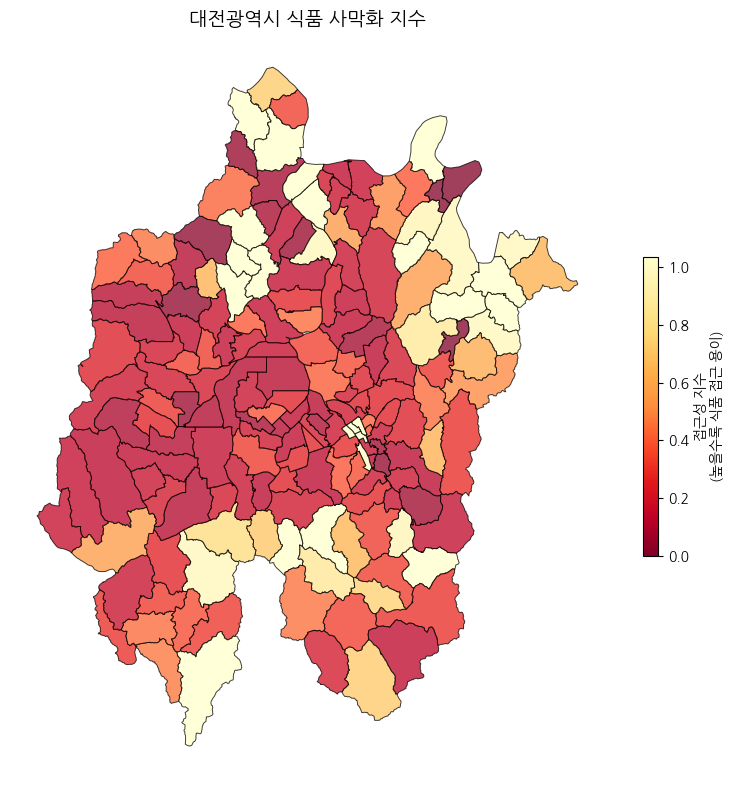

In [52]:
# 히트맵 시각화
fig, ax = plt.subplots(figsize=(8, 8))

daejeon_merged_area.plot(
    column='접근성 지수_clipped',
    ax=ax,
    edgecolor='black',
    linewidth=0.7,
    legend=True,
    cmap='YlOrRd_r',
    alpha=0.75,
    legend_kwds={
        'shrink': 0.4,             
        'label': '접근성 지수\n(높을수록 식품 접근 용이)', 
        'orientation': 'vertical'  
    }

)

ax.set_title('대전광역시 식품 사막화 지수', fontsize=14)
ax.axis('off')
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

In [53]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

def compute_accessibility_score(df, w_area, w_pop, w_elder):
    # 가중치 합이 1이 되도록 보장
    total_weight = w_area + w_pop + w_elder
    if total_weight != 1:
        w_area /= total_weight
        w_pop /= total_weight
        w_elder /= total_weight

    # 접근성 지수 계산
    score = ((df['전체 식료품점'] + 1) /
             (w_area * df['면적(km²)'] +
              w_pop * df['인구'] +
              w_elder * df['65세이상_비율'])) * 10
    return score

# 0.1 단위로 면적/인구/고령비율 가중치 조합 생성 (합 = 1)
weights = np.arange(0, 1.1, 0.1)
weight_combinations = [
    (w1, w2, round(1 - w1 - w2, 1))
    for w1, w2 in itertools.product(weights, repeat=2)
    if 0 <= 1 - w1 - w2 <= 1
]

# 특정 동(예: '중구 은행동')의 지수 변화만 추적해보기
target_area = '대덕구 부수동'  # 여기에 관심 읍면동 이름 입력

results = []

for idx, (w_area, w_pop, w_elder) in enumerate(weight_combinations):
    daejeon_merged_area['접근성 지수'] = compute_accessibility_score(
        daejeon_merged_area, w_area, w_pop, w_elder
    )

    target_score = daejeon_merged_area.loc[
        daejeon_merged_area['시군구+법정동'] == target_area, '접근성 지수'
    ].values[0]

    results.append({
        '조합번호': idx,
        '면적': w_area,
        '인구': w_pop,
        '고령비율': w_elder,
        '접근성 지수': target_score
    })

df_result = pd.DataFrame(results)

In [54]:
top_areas_per_weight = []

for w_area, w_pop, w_elder in weight_combinations:
    daejeon_merged_area['접근성 지수'] = compute_accessibility_score(
        daejeon_merged_area, w_area, w_pop, w_elder
    )
    top_area = daejeon_merged_area.sort_values('접근성 지수', ascending=False).iloc[0]['시군구+법정동']
    top_areas_per_weight.append(top_area)

# 가장 자주 1등한 지역 확인
pd.Series(top_areas_per_weight).value_counts()

대덕구 부수동    35
동구 용계동     11
동구 중동       5
서구 괴정동      4
대덕구 문평동     4
중구 문창동      1
Name: count, dtype: int64

In [55]:
best_combo = None
min_std = float('inf')

for w_area, w_pop, w_elder in weight_combinations:
    daejeon_merged_area['접근성 지수'] = compute_accessibility_score(
        daejeon_merged_area, w_area, w_pop, w_elder
    )

    std = daejeon_merged_area['접근성 지수'].std()

    if std < min_std:
        min_std = std
        best_combo = (w_area, w_pop, w_elder)

print(f"최적 가중치 조합 (불균형 최소화 기준): 면적={best_combo[0]}, 인구={best_combo[1]}, 고령비율={best_combo[2]}")
print(f"접근성 지수 표준편차 = {min_std:.4f}")

최적 가중치 조합 (불균형 최소화 기준): 면적=0.7000000000000001, 인구=0.2, 고령비율=0.1
접근성 지수 표준편차 = 1.9810


In [56]:
# 접근성 지수 기준으로 오름차순 정렬 후 상위 5개 지역 선택
top5_low_access = daejeon_merged_area.sort_values('접근성 지수').head(5)
top5_low_access

,EMD_CD,COL_ADM_SE,EMD_NM,SGG_OID,geometry,법정동,시군구,시군구+법정동,면적(km²),인구,시군구명,종합 소매업,전문 식료품 소매업,편의점,전체 식료품점,65세이상_인구수,65세이상_비율,접근성 지수,접근성 지수_clipped
117,30200107,30200,성북동,490,"POLYGON ((226239.204 414800.629, 226273.671 41...",성북동,유성구,유성구 성북동,10.044951,376.0,유성구,0.0,0.0,0.0,0.0,187.0,0.497340,0.995525,0.121534
16,30110144,30110,상소동,145,"POLYGON ((240839.185 401111.841, 240832.106 40...",상소동,동구,동구 상소동,7.576915,354.0,동구,0.0,0.0,0.0,0.0,177.0,0.500000,1.319798,0.131313
118,30200108,30200,세동,489,"POLYGON ((223900.477 414516.618, 223943.729 41...",세동,유성구,유성구 세동,7.467862,319.0,유성구,0.0,0.0,0.0,0.0,157.0,0.492163,1.339071,0.144767
78,30170124,30170,원정동,388,"POLYGON ((227348.55 405261.155, 227367.08 4052...",원정동,서구,서구 원정동,6.629268,293.0,서구,0.0,0.0,0.0,0.0,132.0,0.450512,1.508462,0.158014
67,30140126,30140,금동,132,"POLYGON ((237049.809 404400.239, 237061.564 40...",금동,중구,중구 금동,5.531382,134.0,중구,0.0,0.0,0.0,0.0,76.0,0.567164,1.807866,0.325429


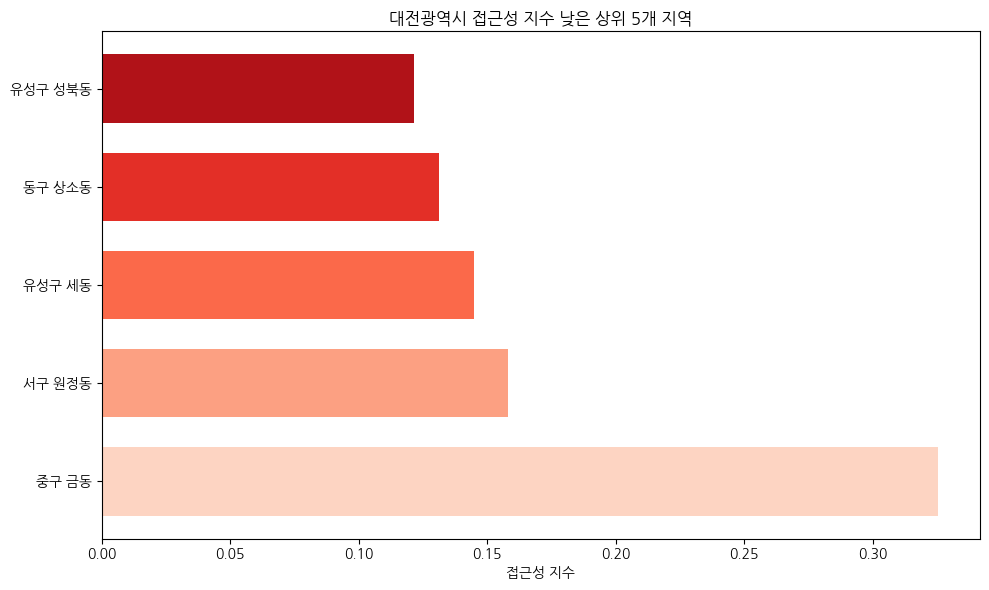

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reds_r 팔레트에서 5개 색상 추출 (접근성 지수 낮은 5개 지역 기준)
colors = sns.color_palette("Reds", n_colors=5)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(top5_low_access['시군구+법정동'][::-1], top5_low_access['접근성 지수_clipped'][::-1], height=0.7, color=colors)
plt.xlabel("지역")
plt.xlabel("접근성 지수")
plt.title("대전광역시 접근성 지수 낮은 상위 5개 지역")
plt.tight_layout()
plt.show()